# Implementation of AlexNet in PyTorch

This notebook is a work in progress.

In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.io import decode_image
from torchinfo import summary

device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print(f"using {device} device")

using cuda device


In [2]:
root_dir = '/home/mateo/Dev/datasets/tiny-imagenet-200'

# train
train_dir = os.path.join(root_dir, 'train')
train_classes = os.listdir(train_dir)
print(f"train classes: {len(train_classes)}")
total_train_images = sum(len(os.listdir(os.path.join(train_dir, cls, 'images'))) for cls in train_classes)
print(f"total train images: {total_train_images}\n")

# test
test_dir = os.path.join(root_dir, 'test', 'images')
total_test_images = len(os.listdir(test_dir))
print(f"total test images: {total_test_images}\n")

# val
val_dir = os.path.join(root_dir, 'val', 'images')
total_val_images = len(os.listdir(val_dir))
print(f"total val images: {total_val_images}")

train classes: 200
total train images: 100000

total test images: 10000

total val images: 10000


In [3]:
def class_mapping():
    class_to_name = {}
    file = open('/home/mateo/Dev/datasets/tiny-imagenet-200/words.txt')
    for line in file:
        cls, name = line.split(maxsplit=1)
        class_to_name[cls] = name.replace('\n', '')
    return class_to_name


name_dict = class_mapping()


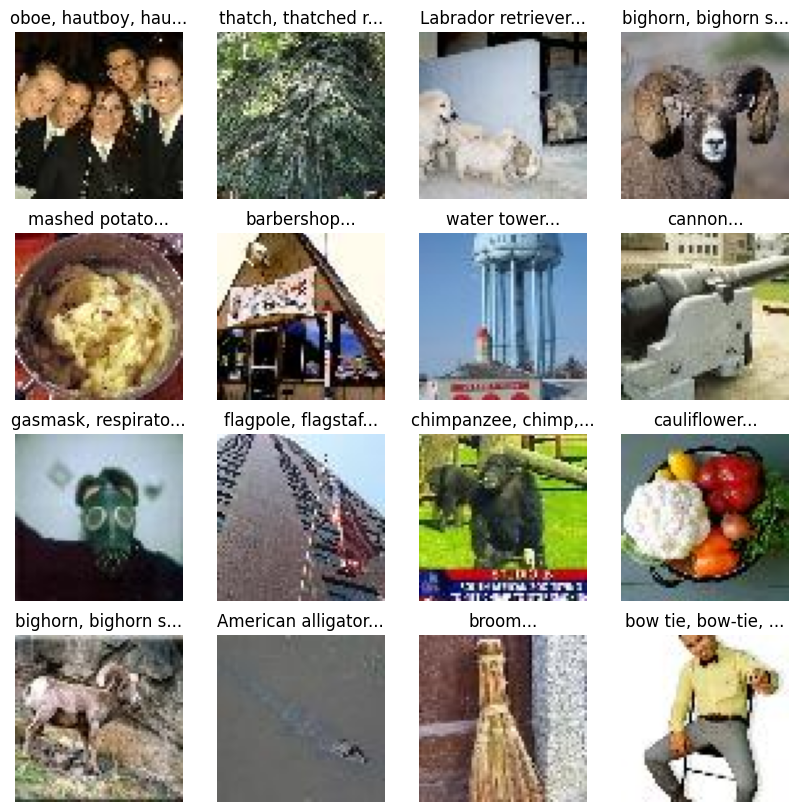

In [4]:
fig = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    cls = random.choice(os.listdir(train_dir))
    img = random.choice(os.listdir(os.path.join(train_dir, cls, 'images')))
    img = Image.open(os.path.join(train_dir, cls, 'images', img))
    fig.add_subplot(rows, cols, i)
    plt.title(name_dict[cls][:18] + "...")
    plt.axis('off')
    plt.imshow(img)
plt.show()

## Dataset
- The original ImageNet-1k requires registration and is also huge
- Splits available on kaggle, such as ImageNet-100 could be used
- Here we use TinyImageNet, which has:
    - train classes: 200
    - total train images: 100000
    - total test images: 10000
    - total val images: 10000

- However, the original AlexNet architecture (which we are trying to replicate) expects the 224x224 input, while TinyImageNet uses 64x64
- For that reason, we upscale the images, which is a bad solution - instead, a different dataset should be used or the architecture should be adjusted
- However, we want to replicate the architecture as close as possible and make it possible to just replace the dataset with the actual ImageNet dataset without having to rewrite the architecture.

In [ ]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        # load class IDs
        wnids_path = os.path.join(root_dir, 'wnids.txt')
        with open(wnids_path, 'r') as f:
            self.wnids = [line.strip() for line in f]
        self.wnids.sort()
        self.class_to_idx = {wnid: idx for idx, wnid in enumerate(self.wnids)}
        self.idx_to_class = self.wnids

        self.img_paths = []
        self.labels = []

        if split == 'train':
            self._load_train_data()
        elif split == 'val':
            self._load_val_data()
        elif split == 'test':
            self._load_test_data()
        else:
            raise ValueError(f"Invalid split: {split}")
        
    def _load_train_data(self):
        train_dir = os.path.join(self.root_dir, 'train')
        for wnid in self.wnids:
            class_dir = os.path.join(train_dir, wnid, 'images')
            if not os.path.isdir(class_dir):
                continue # skip if class is missing (shouldn't happen)
            for img_name in os.listdir(class_dir):
                self.img_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[wnid])

    def _load_val_data(self):
        val_dir = os.path.join(self.root_dir, 'val')
        images_dir = os.path.join(val_dir, 'images')
        annotations_file = os.path.join(val_dir, 'val_annotations.txt')
        img_to_wnid = {}

        # load annotations
        with open(annotations_file, 'r') as f:
            for line in f:
                img_name, wnid, _, _, _, _  = line.strip().split('\t') # ignore bounding boxes
                img_to_wnid[img_name] = wnid

        for img_name in os.listdir(images_dir):
            img_path = os.path.join(images_dir, img_name)
            wnid = img_to_wnid.get(img_name, None)
            if wnid not in self.class_to_idx:
                continue # skip if invalid class (shouldn't happen)
            self.img_paths.append(img_path)
            self.labels.append(self.class_to_idx[wnid])

    def _load_test_data(self):
        test_dir = os.path.join(self.root_dir, 'test', 'images')
        for img_name in os.listdir(test_dir):
            self.img_paths.append(os.path.join(test_dir, img_name))
            self.labels.append(-1) # placeholder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label
        

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

train_data = TinyImageNetDataset(root_dir, split='train', transform=transform)

In [7]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


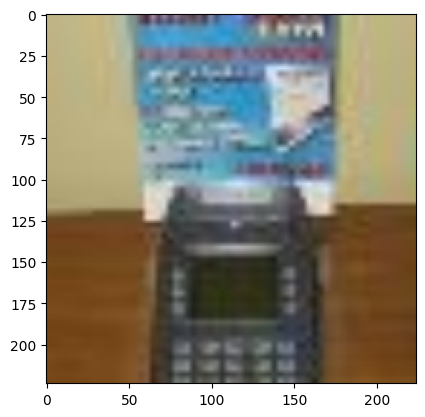

Label: 86


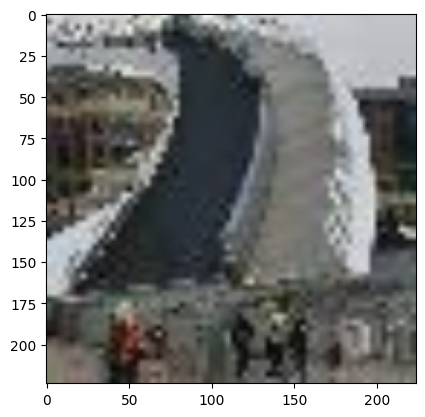

Label: 154


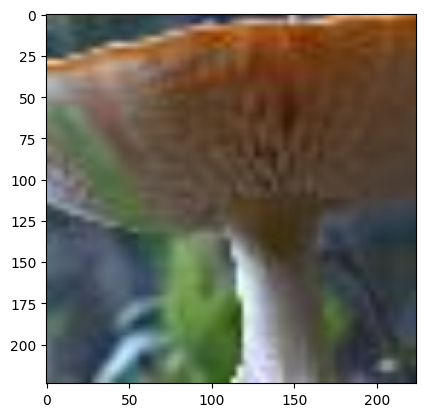

Label: 185


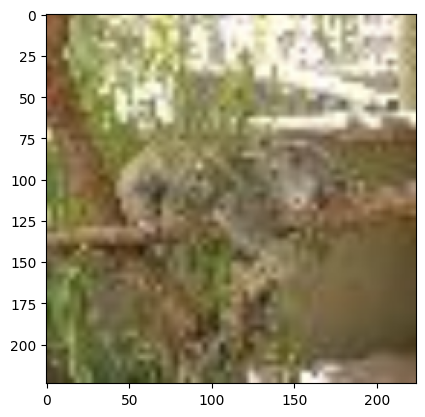

Label: 12


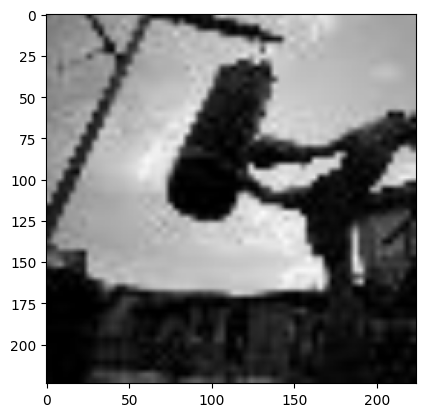

Label: 138


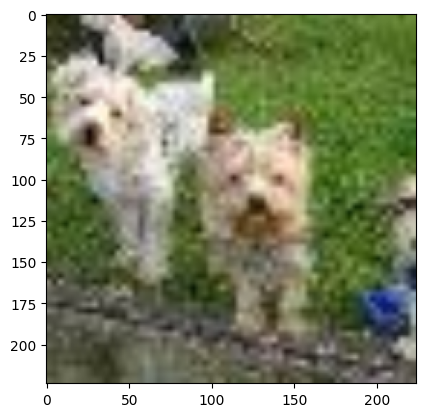

Label: 25


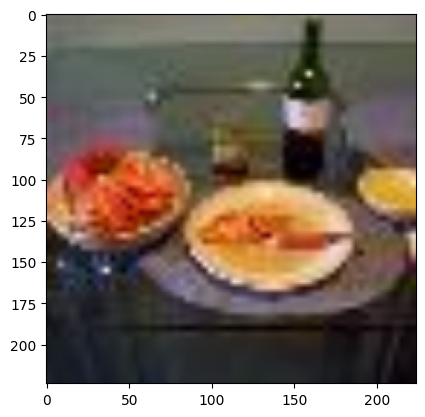

Label: 18


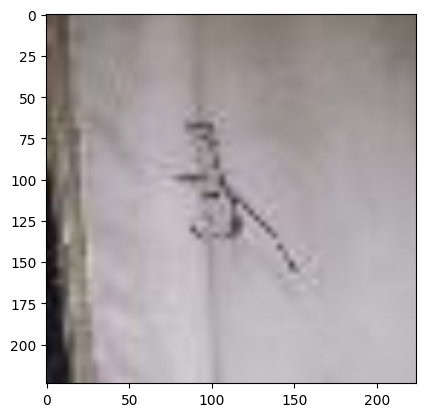

Label: 40


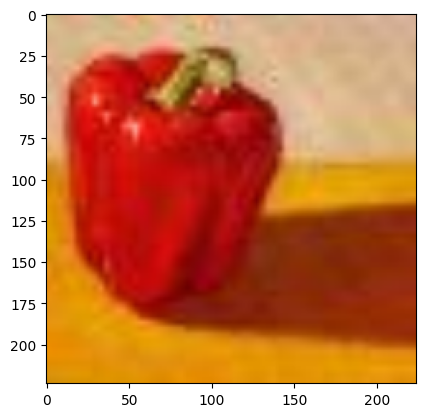

Label: 184


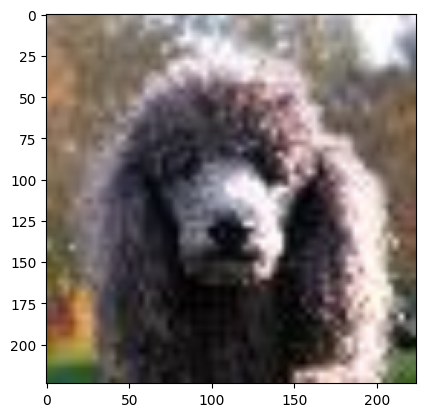

Label: 29


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
for i in range(10):
    img = np.transpose(train_features[i], (1, 2, 0))
    label = train_labels[i]
    plt.imshow(img, cmap='gray')
    plt.show()
    print(f"Label: {label}")

## Architecture

0. input layer
1. 

- 8 layers
    - first 5 convs
    - last 3 dense
    - then softmax
- local response normalization follow first and second conv layers
- max-pooling follows both normalization layers and the fifth conv
- relu follows very conv layer and dense layer

- input is 224x224x3
- c1 - 96 filters 11x11x3, stride 4
- c2 - input is normalized and pooled output of c1, 256 filters 5x5x48
- c3 and c4 are without pooling and normalization
- c3 - 384 filters 3x3x256
- c4 - 384 filters 3x3x192
- c5 - 256 filtrs 3x3x192
- dense layers have 4096 neurons

=>
- input - 224x224x3
- c1 - 96 11x11x3 filters, s=4, p=0
- relu
- local response normalization
- overlapped maxpool s=2, 3x3 filter
- c2 - 256 5x5x48 filters, s=1, p=2
- relu
- local response normalization
- overlapped maxpool s=2, 3x3 filter
- c3 - 384 3x3x256 filters, s1, p=1
- relu
- c4 - 384 3x3x192 filters, s=1, p=1
- relu
- c5 - 256 3x3x192 filters, s=1, p=1
- relu
- overlapped maxpool s=2, 3x3 filter
- fc6 - 4096 neurons
- relu
- fc7 - 4096 neurons
- relu
- fc8 - 1000 neurons
- softmax

pooling:
- overlapping, so stride is smaller than filter size
- uses s=2 (stride) and z=3 (filter size)

optimization:
- maximizs the multinomial logistic regression objective, i.e. maximizing the average across training cases of the log-probability of he correct label under the prediction distribution


In [9]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.c2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.c3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.c4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.c5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc6 = nn.Linear(5 * 5 * 256, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 200)

        self.norm = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2)


    def forward(self, x):
        x = F.relu(self.c1(x))
        x = self.pool(self.norm(x))
        x = F.relu(self.c2(x))
        x = self.pool(self.norm(x))
        x = F.relu(self.c3(x))
        x = F.relu(self.c4(x))
        x = F.relu(self.c5(x))
        x = self.pool(x)
        x = x.view(-1, 5 * 5 * 256)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)

        return x

In [10]:
model = AlexNet().to(device)
print(model)

AlexNet(
  (c1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (c2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Linear(in_features=6400, out_features=4096, bias=True)
  (fc7): Linear(in_features=4096, out_features=4096, bias=True)
  (fc8): Linear(in_features=4096, out_features=200, bias=True)
  (norm): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
)


In [12]:
batch_size = 64
epochs = 10
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0.
    last_loss = 0.
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        preds = model(X)
        loss = loss_fn(preds, y)
        correct = preds.argmax(1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch % 100 == 0:
            last_loss = running_loss / 100
            current = (batch + 1) * len(X)
            print(f"loss: {last_loss:>7f} [{current:>5d}/{size:>5d}]")
        
    return last_loss

In [ ]:
train_loss_history = []

for t in range(epochs):
    print(f"\nEpoch [{t + 1}/{epochs}], Learning Rate: {learning_rate}\n----------------------------------")
    avg_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_loss_history.append(avg_loss)
print("Done!")


In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
dummy_label = torch.tensor([0]).to(device)
optimizer.zero_grad()

output = model(dummy_input)
loss = loss_fn(output, dummy_label)
loss.backward()

grad_norm = model.c1.weight.grad.norm().item()
print("Gradient norm for c1:", grad_norm)

Gradient norm for c1: 0.024944081902503967


In [73]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} grad norm: {param.grad.norm().item()}")

c1.weight grad norm: 0.024944081902503967
c1.bias grad norm: 0.0014343735529109836
c2.weight grad norm: 0.10917088389396667
c2.bias grad norm: 0.004096935037523508
c3.weight grad norm: 0.13150475919246674
c3.bias grad norm: 0.014045855961740017
c4.weight grad norm: 0.14385077357292175
c4.bias grad norm: 0.03175724297761917
c5.weight grad norm: 0.15242315828800201
c5.bias grad norm: 0.08077986538410187
fc6.weight grad norm: 0.2668832540512085
fc6.bias grad norm: 0.16894793510437012
fc7.weight grad norm: 0.25199979543685913
fc7.bias grad norm: 0.41574013233184814
fc8.weight grad norm: 0.47648894786834717
fc8.bias grad norm: 0.997471809387207
